<a href="https://colab.research.google.com/github/sava-stew/Principles-of-Data-Science-FinalProject/blob/main/speech_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
import tensorflow as tf
import IPython.display as ipd

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -o "/content/drive/MyDrive/Colab Notebooks/speech-emotion-recognition-ravdess-data.zip" -d "./ravdess_data"

Archive:  /content/drive/MyDrive/Colab Notebooks/speech-emotion-recognition-ravdess-data.zip
   creating: ./ravdess_data/Actor_01/
  inflating: ./ravdess_data/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: ./ravdess_data/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: ./ravdess_data/Actor_01/

# Path to Audio Data

In [ ]:
# Define dataset path
dataset_path = "./ravdess_data"

# Verify if dataset path exists
if os.path.isdir(dataset_path):
    print("Dataset extracted successfully!")
    actor_folders = os.listdir(dataset_path)
    print(f"Total Actor Folders: {len(actor_folders)}")
    print(f"Sample Actor Folders: {actor_folders[:5]}")
else:
    print("Extraction failed.")

# Get list of all .wav files
audio_files = []
for actor_folder in actor_folders:
    actor_path = os.path.join(dataset_path, actor_folder)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                audio_files.append(os.path.join(actor_path, file))

# Print total files and a few sample file paths
print(f"Total audio files: {len(audio_files)}")
print(f"Sample file paths:\n{audio_files[:5]}")

Dataset extracted successfully!
Total Actor Folders: 24
Sample Actor Folders: ['Actor_15', 'Actor_19', 'Actor_11', 'Actor_07', 'Actor_14']
Total audio files: 1440
Sample file paths:
['./ravdess_data/Actor_15/03-01-08-01-01-02-15.wav', './ravdess_data/Actor_15/03-01-05-02-02-01-15.wav', './ravdess_data/Actor_15/03-01-05-02-01-02-15.wav', './ravdess_data/Actor_15/03-01-06-02-02-01-15.wav', './ravdess_data/Actor_15/03-01-02-02-01-01-15.wav']


# Extract labels and features to dataframe

In [ ]:
def extract_labels(filename):
    """Extracts all relevant labels from the RAVDESS filename based on Codebook."""
    emotion_dict = {
        "01": "Neutral",
        "02": "Calm",
        "03": "Happy",
        "04": "Sad",
        "05": "Angry",
        "06": "Fearful",
        "07": "Disgust",
        "08": "Surprised"
    }

    intensity_dict = {"01": "Normal", "02": "Strong"}
    statement_dict = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}

    try:
        parts = filename.split("-")
        actor_id = int(parts[6].split(".")[0])

        return {
            "Modality": "Audio-only" if parts[0] == "03" else "Unknown",
            "Vocal Channel": "Speech" if parts[1] == "01" else "Unknown",
            "Emotion": emotion_dict.get(parts[2], "Unknown"),
            "Intensity": intensity_dict.get(parts[3], "Unknown"),
            "Statement": statement_dict.get(parts[4], "Unknown"),
            "Repetition": int(parts[5]),
            "Actor ID": actor_id,
            "Gender": "Male" if actor_id % 2 == 1 else "Female"
        }
    except IndexError:
        return {"Error": "Invalid Filename"}

In [ ]:
# Create a list of dictionaries with file paths and labels
audio_data = [{**extract_labels(os.path.basename(file)), "File Path": file} for file in audio_files]

# Convert to data frame to view
labels_df = pd.DataFrame(audio_data)
labels_df.head(10)

,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor ID,Gender,File Path
0,Audio-only,Speech,Surprised,Normal,Kids are talking by the door,2,15,Male,./ravdess_data/Actor_15/03-01-08-01-01-02-15.wav
1,Audio-only,Speech,Angry,Strong,Dogs are sitting by the door,1,15,Male,./ravdess_data/Actor_15/03-01-05-02-02-01-15.wav
2,Audio-only,Speech,Angry,Strong,Kids are talking by the door,2,15,Male,./ravdess_data/Actor_15/03-01-05-02-01-02-15.wav
3,Audio-only,Speech,Fearful,Strong,Dogs are sitting by the door,1,15,Male,./ravdess_data/Actor_15/03-01-06-02-02-01-15.wav
4,Audio-only,Speech,Calm,Strong,Kids are talking by the door,1,15,Male,./ravdess_data/Actor_15/03-01-02-02-01-01-15.wav
5,Audio-only,Speech,Happy,Strong,Kids are talking by the door,1,15,Male,./ravdess_data/Actor_15/03-01-03-02-01-01-15.wav
6,Audio-only,Speech,Disgust,Normal,Kids are talking by the door,2,15,Male,./ravdess_data/Actor_15/03-01-07-01-01-02-15.wav
7,Audio-only,Speech,Surprised,Normal,Kids are talking by the door,1,15,Male,./ravdess_data/Actor_15/03-01-08-01-01-01-15.wav
8,Audio-only,Speech,Surprised,Strong,Dogs are sitting by the door,1,15,Male,./ravdess_data/Actor_15/03-01-08-02-02-01-15.wav
9,Audio-only,Speech,Happy,Normal,Dogs are sitting by the door,2,15,Male,./ravdess_data/Actor_15/03-01-03-01-02-02-15.wav


In [ ]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Modality       1440 non-null   object
 1   Vocal Channel  1440 non-null   object
 2   Emotion        1440 non-null   object
 3   Intensity      1440 non-null   object
 4   Statement      1440 non-null   object
 5   Repetition     1440 non-null   int64 
 6   Actor ID       1440 non-null   int64 
 7   Gender         1440 non-null   object
 8   File Path      1440 non-null   object
dtypes: int64(2), object(7)
memory usage: 101.4+ KB


In [ ]:
labels_df['Emotion'].value_counts()

,count
Emotion,
Surprised,192
Angry,192
Fearful,192
Calm,192
Happy,192
Disgust,192
Sad,192
Neutral,96


In [ ]:
labels_df['Intensity'].value_counts()

,count
Intensity,
Normal,768
Strong,672


In [ ]:
labels_df['Gender'].value_counts()


,count
Gender,
Male,720
Female,720


# **Data Visualiation**



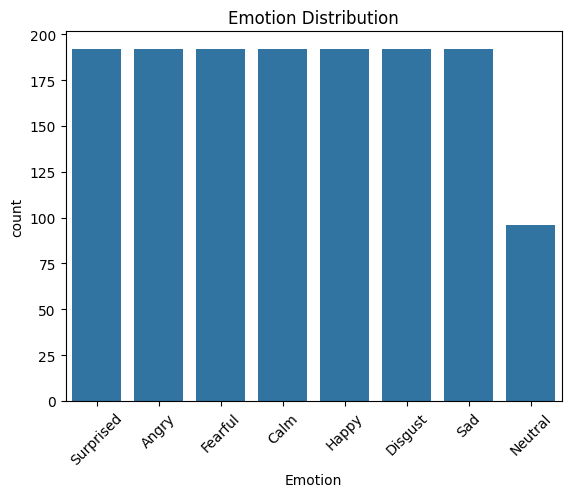

In [ ]:
# Emotion Distribution

sns.countplot(data=labels_df, x='Emotion', order=labels_df['Emotion'].value_counts().index)
plt.title('Emotion Distribution')
plt.xticks(rotation=45)
plt.show()


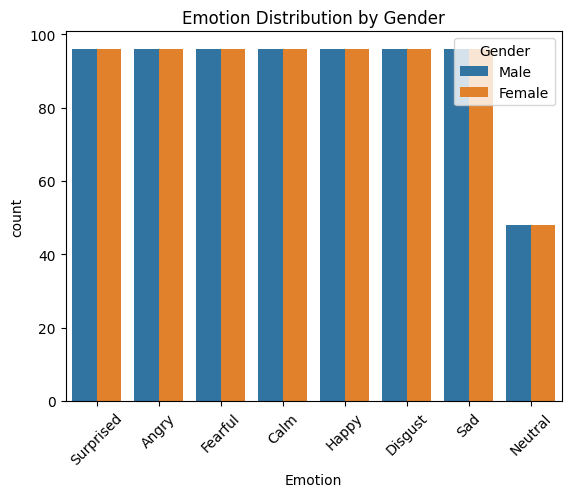

In [ ]:
# Emotion by Gender
sns.countplot(data=labels_df, x='Emotion', hue='Gender')
plt.title('Emotion Distribution by Gender')
plt.xticks(rotation=45)
plt.show()


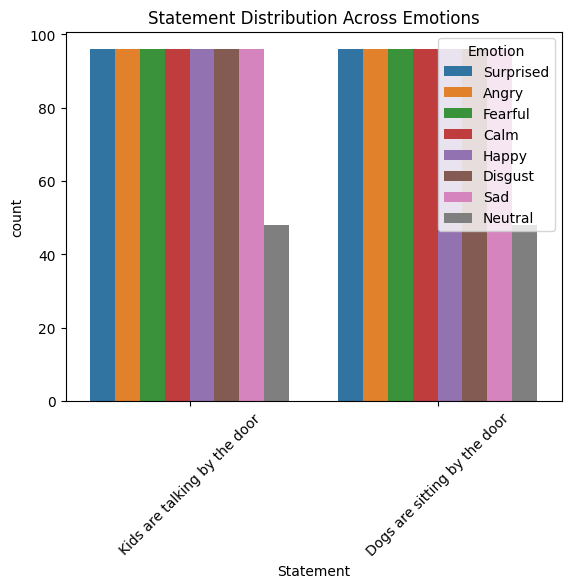

In [ ]:
# Statement Usage
sns.countplot(data=labels_df, x='Statement', hue='Emotion')
plt.title('Statement Distribution Across Emotions')
plt.xticks(rotation=45)
plt.show()


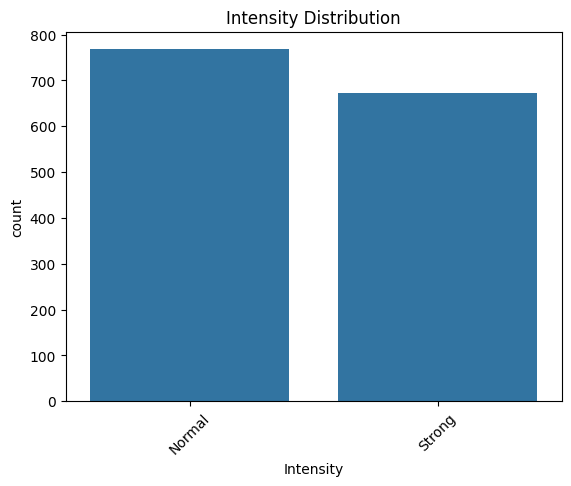

In [ ]:
#Intensity Distribution

sns.countplot(data=labels_df, x='Intensity', order=labels_df['Intensity'].value_counts().index)
plt.title('Intensity Distribution')
plt.xticks(rotation=45)
plt.show()

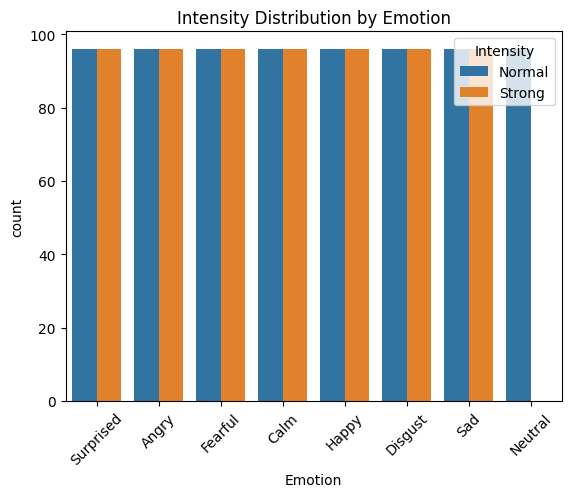

In [ ]:
#Intensity Distribution by Emotion
sns.countplot(data=labels_df, x='Emotion', hue='Intensity', order=labels_df['Emotion'].value_counts().index)
plt.title('Intensity Distribution by Emotion')
plt.xticks(rotation=45)
plt.show()

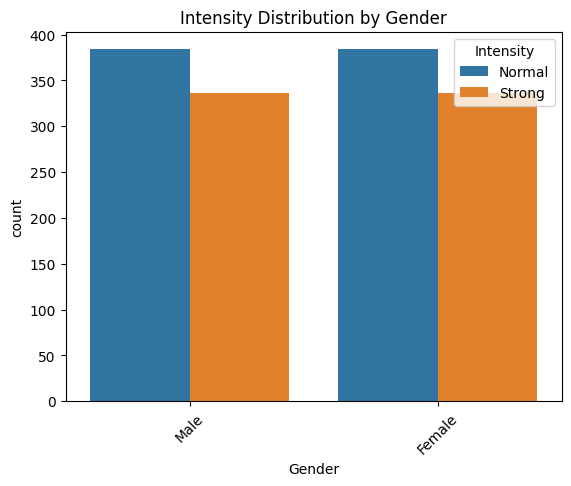

In [ ]:
#Intensity Distribution by Gender
sns.countplot(data=labels_df, x='Gender', hue='Intensity')
plt.title('Intensity Distribution by Gender')
plt.xticks(rotation=45)
plt.show()

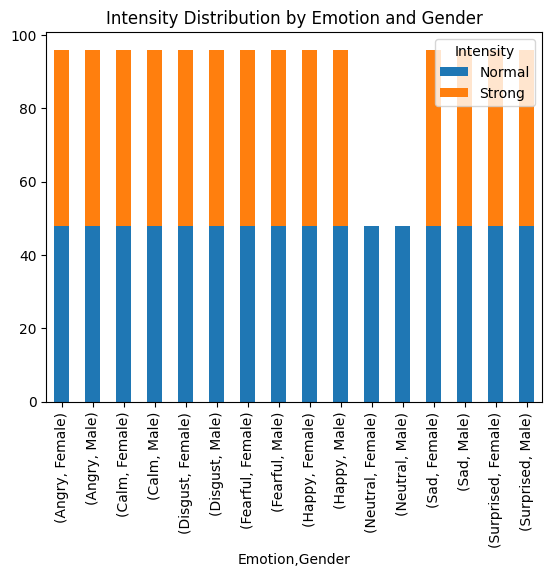

In [ ]:
#Intensity Distribution by Emotion and Gender
labels_df.groupby(['Emotion', 'Gender', 'Intensity']).size().unstack().plot(kind='bar', title= 'Intensity Distribution by Emotion and Gender', stacked=True)
plt.show()

In [ ]:
def extract_features(file_path):
    """Extracts MFCC (Mel-Frequency Cepstral Coefficients: Captures timbral features) features from an audio file."""
    # Can find more features specific to audio and add to this function to train model on
    try:
        y, sr = librosa.load(file_path, sr=16000) # sampling rate: 16kHz (common in speech processing)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs
        if mfccs.shape[1] > 0:             # Check if MFCCs were successfully computed
            return np.mean(mfccs, axis=1)  # Take mean across time frames
        else:
            return None

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
def extract_melScale(file_path):
  try:
    y, sr = librosa.load(file_path, sr = 16000)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels = 26) #Extract 26 bins
    return np.mean(mel_spectrogram, axis =1)
  except Exception as e:
    print(f'Error processing {file_path}: {e}')
    return None

In [ ]:
def extract_tempo(file_path):
  try:
    y, sr = librosa.load(file_path, sr = 16000)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)
    return tempo
  except Exception as e:
    print(f"Error processing {file_path}: {e}")
    return None

In [ ]:
def extract_brightness(file_path):
  try:
    y, sr = librosa.load(file_path, sr = 16000)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(cent, axis=1)
  except Exception as e:
    print(f"Error processing {file_path}: {e}")
    return None

In [ ]:
import sys

np.set_printoptions(threshold = sys.maxsize)

def extract_pitch(file_path):
  try:
    y, sr = librosa.load(file_path, sr = 16000)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    max_indexes = np.argmax(magnitudes, axis=0)
    #find pitch based off of frequency for a given time
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return np.mean(pitches)
  except Exception as e:
    print(f"Error processing {file_path}: {e}")
    return None

In [ ]:
data = []
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)

    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)
                features = extract_features(file_path)
                mel_spectograms = extract_melScale(file_path)
                tempos = extract_tempo(file_path)
                pitches = extract_pitch(file_path)
                brightness = extract_brightness(file_path)

                labels = extract_labels(file)

                if features is not None and len(features) == 13 and len(mel_spectograms) == 26:
                    data.append([file] + list(features) + list(mel_spectograms) + list(tempos) + [pitches] + list(brightness) + list(labels.values()))
            # break

# Convert to DataFrame
columns = ["Filename"] + [f"MFCC_{i}" for i in range(13)] + [f"Mel-Bin_{i}" for i in range(26)] + ["Tempo", "Pitches", "Brightness", "Modality", "Vocal Channel", "Emotion", "Intensity", "Statement", "Repetition", "Actor ID", "Gender"]
labels_features_df = pd.DataFrame(data, columns=columns)

In [ ]:
labels_features_df.columns

Index(['Filename', 'MFCC_0', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5',
       'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'Mel-Bin_0', 'Mel-Bin_1', 'Mel-Bin_2', 'Mel-Bin_3', 'Mel-Bin_4',
       'Mel-Bin_5', 'Mel-Bin_6', 'Mel-Bin_7', 'Mel-Bin_8', 'Mel-Bin_9',
       'Mel-Bin_10', 'Mel-Bin_11', 'Mel-Bin_12', 'Mel-Bin_13', 'Mel-Bin_14',
       'Mel-Bin_15', 'Mel-Bin_16', 'Mel-Bin_17', 'Mel-Bin_18', 'Mel-Bin_19',
       'Mel-Bin_20', 'Mel-Bin_21', 'Mel-Bin_22', 'Mel-Bin_23', 'Mel-Bin_24',
       'Mel-Bin_25', 'Tempo', 'Pitches', 'Brightness', 'Modality',
       'Vocal Channel', 'Emotion', 'Intensity', 'Statement', 'Repetition',
       'Actor ID', 'Gender'],
      dtype='object')

In [ ]:
labels_features_df['Emotion']

,Emotion
0,Surprised
1,Angry
2,Angry
3,Fearful
4,Calm
...,...
1435,Angry
1436,Surprised
1437,Surprised
1438,Sad


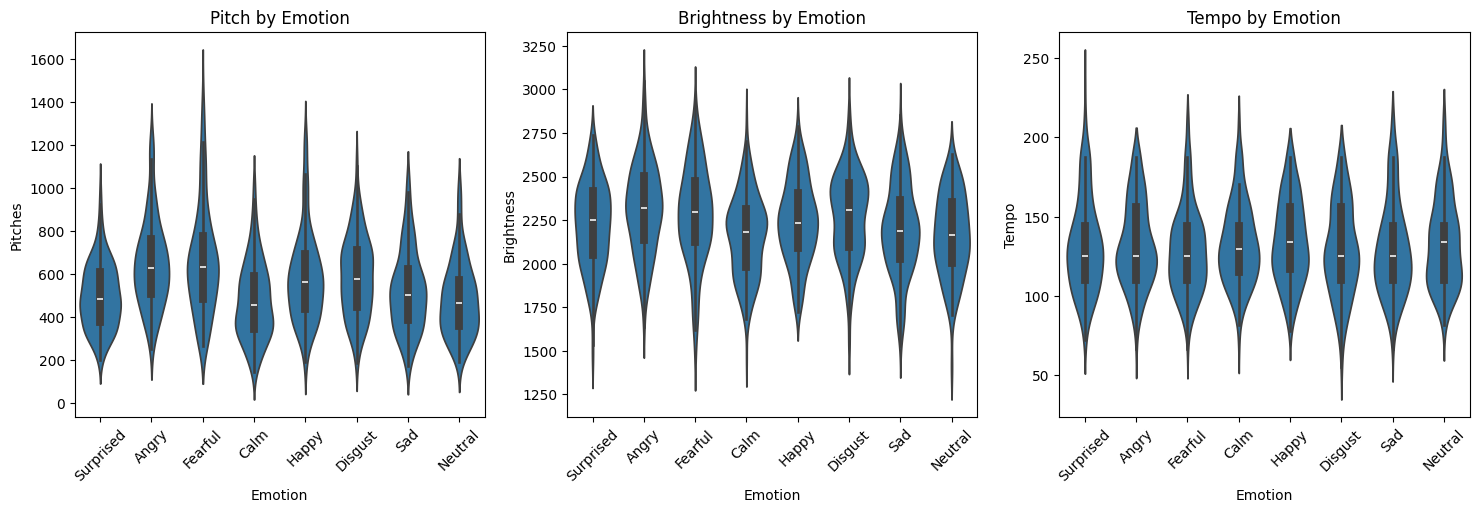

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.violinplot(data=labels_features_df, x='Emotion', y='Pitches', ax=axes[0])
axes[0].set_title('Pitch by Emotion')
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(data=labels_features_df, x='Emotion', y='Brightness', ax=axes[1])
axes[1].set_title('Brightness by Emotion')
axes[1].tick_params(axis='x', rotation=45)

sns.violinplot(data=labels_features_df, x='Emotion', y='Tempo', ax=axes[2])
axes[2].set_title('Tempo by Emotion')
axes[2].tick_params(axis='x', rotation=45)

plt.show()


# Encode Categorical Values to Numeric Values

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Intensity', 'Statement', 'Gender']
df_encoded = labels_features_df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
df_encoded.head()

,Filename,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,...,Pitches,Brightness,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor ID,Gender
0,03-01-08-01-01-02-15.wav,-573.052856,58.117954,-7.012194,17.885029,1.848936,1.855840,0.162962,-5.099564,1.142244,...,394.941467,1942.570176,Audio-only,Speech,Surprised,0,1,2,15,1
1,03-01-05-02-02-01-15.wav,-483.332916,42.281872,-7.701275,16.793240,3.228414,-4.141271,-1.940905,-4.243218,-1.976512,...,394.861237,2049.441866,Audio-only,Speech,Angry,1,0,1,15,1
2,03-01-05-02-01-02-15.wav,-440.675507,40.124874,-13.714140,8.601620,-8.864114,-4.431196,0.891086,-9.404708,-2.639452,...,621.688416,2284.630810,Audio-only,Speech,Angry,1,1,2,15,1
3,03-01-06-02-02-01-15.wav,-514.645447,44.250874,-4.146979,21.176739,4.260562,-3.641764,-0.973128,-4.994734,2.122894,...,556.349854,1803.363550,Audio-only,Speech,Fearful,1,0,1,15,1
4,03-01-02-02-01-01-15.wav,-637.812866,70.385284,3.553671,18.022158,2.501895,1.222821,-0.491463,1.070319,-3.871606,...,405.401367,1999.971331,Audio-only,Speech,Calm,1,1,1,15,1


# Random Forest Classifier

In [ ]:
X = df_encoded.drop(['Filename', 'Emotion', 'Modality', 'Vocal Channel'], axis=1)
emotion_encoder = LabelEncoder()
y = emotion_encoder.fit_transform(df_encoded['Emotion'])
X.head()

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,Mel-Bin_24,Mel-Bin_25,Tempo,Pitches,Brightness,Intensity,Statement,Repetition,Actor ID,Gender
0,-573.052856,58.117954,-7.012194,17.885029,1.848936,1.855840,0.162962,-5.099564,1.142244,1.319685,...,0.000034,0.000026,133.928571,394.941467,1942.570176,0,1,2,15,1
1,-483.332916,42.281872,-7.701275,16.793240,3.228414,-4.141271,-1.940905,-4.243218,-1.976512,2.009286,...,0.001699,0.001209,187.500000,394.861237,2049.441866,1,0,1,15,1
2,-440.675507,40.124874,-13.714140,8.601620,-8.864114,-4.431196,0.891086,-9.404708,-2.639452,-3.476216,...,0.000811,0.000522,117.187500,621.688416,2284.630810,1,1,2,15,1
3,-514.645447,44.250874,-4.146979,21.176739,4.260562,-3.641764,-0.973128,-4.994734,2.122894,-1.284173,...,0.000936,0.000481,78.125000,556.349854,1803.363550,1,0,1,15,1
4,-637.812866,70.385284,3.553671,18.022158,2.501895,1.222821,-0.491463,1.070319,-3.871606,2.375240,...,0.000046,0.000025,125.000000,405.401367,1999.971331,1,1,1,15,1


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1152, 47)
(1152,)
(288, 47)
(288,)


In [ ]:
forest_classifier = RandomForestClassifier(max_features=6,
                                           random_state=42,
                                          n_estimators=700,
                                          criterion='gini',
                                          max_depth=None)


forest_classifier.fit(X_train, y_train) # train the model
y_pred = forest_classifier.predict(X_test) # test the model

y_test_labels = emotion_encoder.inverse_transform(y_test)
y_pred_labels = emotion_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

Accuracy:  0.5798611111111112

Classification Report:
               precision    recall  f1-score   support

       Angry       0.71      0.71      0.71        38
        Calm       0.54      0.79      0.64        38
     Disgust       0.51      0.58      0.54        38
     Fearful       0.66      0.54      0.59        39
       Happy       0.52      0.56      0.54        39
     Neutral       0.73      0.42      0.53        19
         Sad       0.59      0.53      0.56        38
   Surprised       0.53      0.44      0.48        39

    accuracy                           0.58       288
   macro avg       0.60      0.57      0.57       288
weighted avg       0.59      0.58      0.58       288



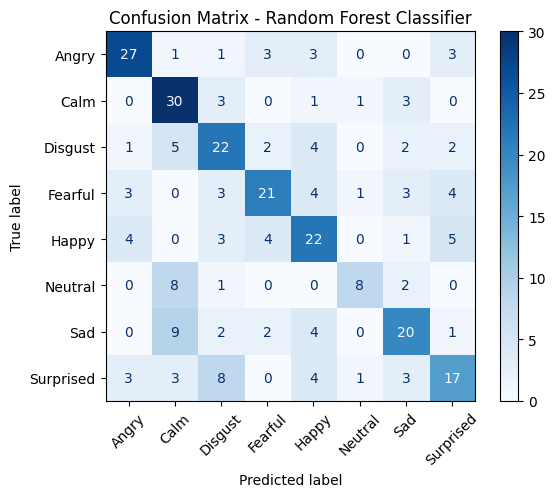

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=emotion_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

<Axes: >

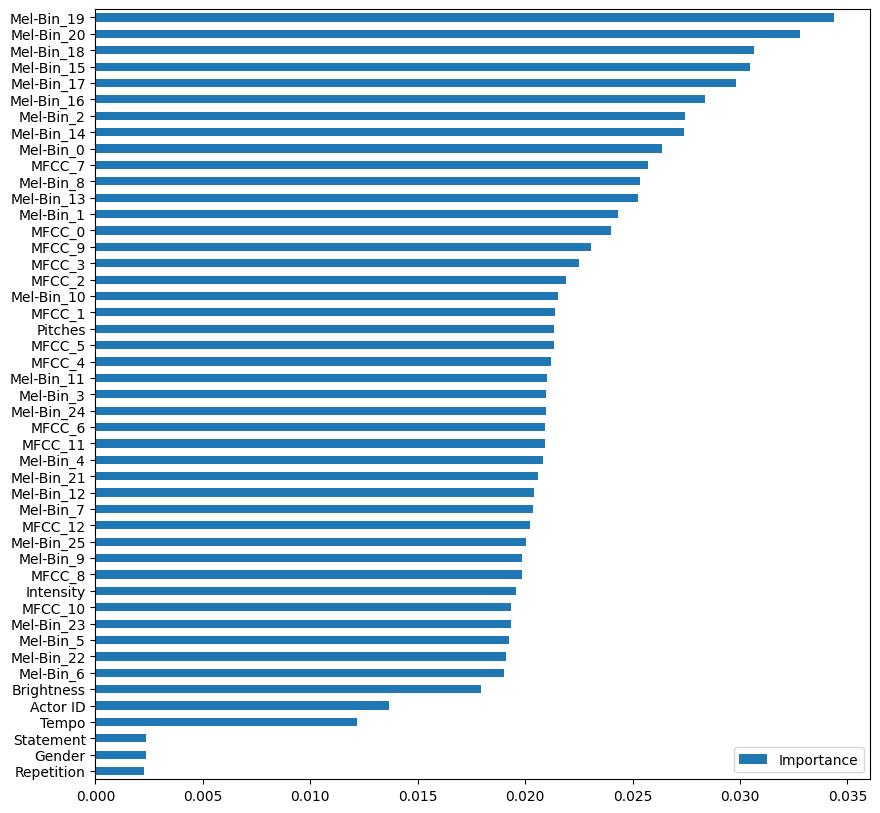

In [ ]:
# get the feature importance
importance = pd.DataFrame({'Importance':forest_classifier.feature_importances_},
                          index = X_train.columns)
importance = importance.sort_values(by='Importance', axis=0, ascending=True)
importance.plot(kind='barh', figsize=(10, 10))

In [ ]:
'''from sklearn.model_selection import RandomizedSearchCV

# Define the classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [300, 500, 700],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the random search
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings sampled
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1   # Use all CPU cores
)

# Fit the search object to your training data
search.fit(X_train, y_train)

# Best model
best_rf = search.best_estimator_
print("Best Parameters:", search.best_params_)'''


'from sklearn.model_selection import RandomizedSearchCV\n\n# Define the classifier\nrf = RandomForestClassifier(random_state=42)\n\n# Define the hyperparameter grid\nparam_dist = {\n    \'n_estimators\': [300, 500, 700],\n    \'max_depth\': [10, 20, None],\n    \'max_features\': [\'sqrt\', \'log2\', None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\n# Setup the random search\nsearch = RandomizedSearchCV(\n    estimator=rf,\n    param_distributions=param_dist,\n    n_iter=30,  # Number of parameter settings sampled\n    cv=5,       # 5-fold cross-validation\n    scoring=\'accuracy\',\n    random_state=42,\n    n_jobs=-1   # Use all CPU cores\n)\n\n# Fit the search object to your training data\nsearch.fit(X_train, y_train)\n\n# Best model\nbest_rf = search.best_estimator_\nprint("Best Parameters:", search.best_params_)'

In [ ]:
!pip install xgboost
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(emotion_encoder.classes_),
    max_depth=None,
    learning_rate=0.1,
    n_estimators=700,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_test_labels = emotion_encoder.inverse_transform(y_test)
y_pred_labels = emotion_encoder.inverse_transform(y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:35:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.65625

Classification Report:
               precision    recall  f1-score   support

       Angry       0.78      0.76      0.77        38
        Calm       0.67      0.82      0.74        38
     Disgust       0.68      0.66      0.67        38
     Fearful       0.69      0.74      0.72        39
       Happy       0.58      0.64      0.61        39
     Neutral       0.56      0.47      0.51        19
         Sad       0.68      0.55      0.61        38
   Surprised       0.56      0.51      0.53        39

    accuracy                           0.66       288
   macro avg       0.65      0.65      0.65       288
weighted avg       0.66      0.66      0.65       288



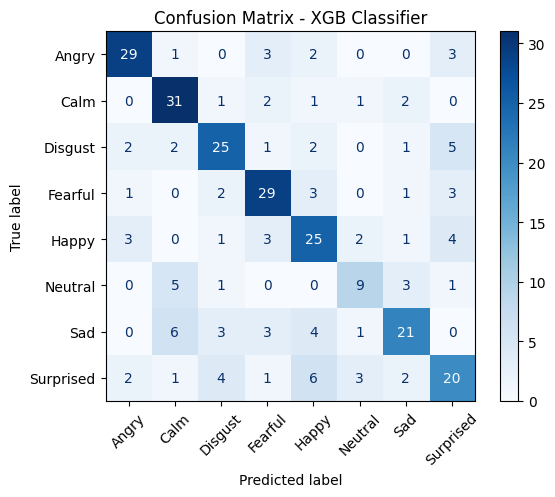

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=emotion_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGB Classifier")
plt.show()

<Axes: >

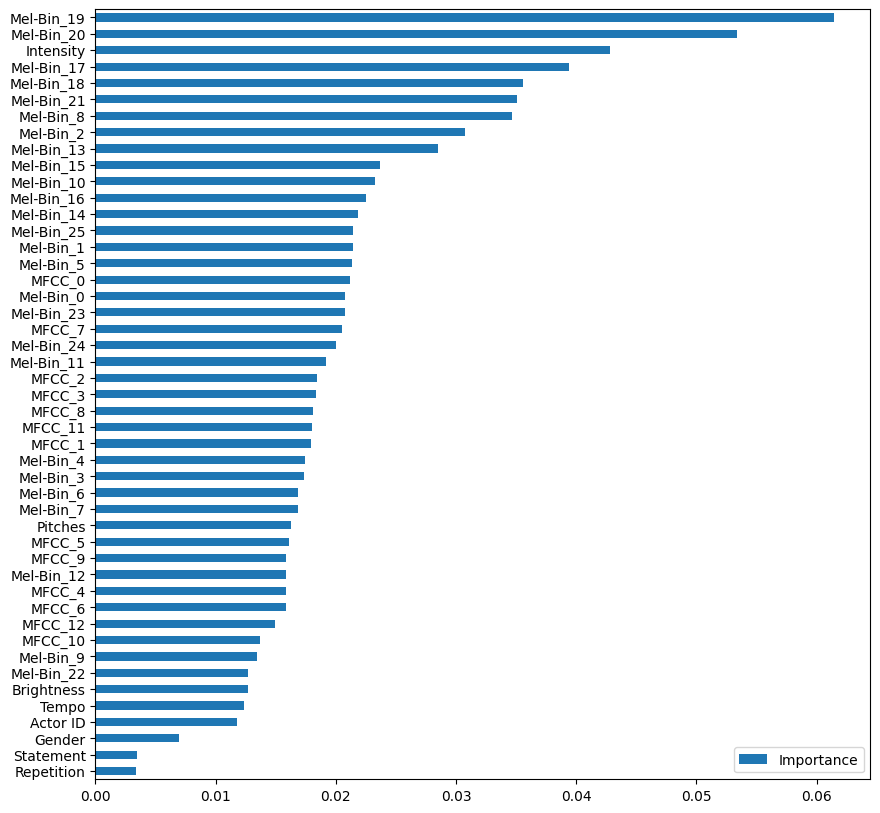

In [ ]:
# get the feature importance
importance = pd.DataFrame({'Importance':xgb_model.feature_importances_},
                          index = X_train.columns)
importance = importance.sort_values(by='Importance', axis=0, ascending=True)
importance.plot(kind='barh', figsize=(10, 10))

Used CNN to check whether we can get higher accuracy than random forest. Here this will construct a image in 2D and try to find pattern of an emotion. NN said to be more accurate in recognising emotion patterns.